# Kinematic analysis of J0332-00

Author: [Kiara Hervella](https://www.linkedin.com/in/kiara-hervella/)

## Initialisation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('tab10',8)
sns.set_style('whitegrid')
import numpy as np

from astropy.modeling import models, fitting
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.analysis import line_flux

import astropy.units as u
from astropy.table import QTable, Table
from astropy.io import ascii

from tied_parameters import *
from aux_functions import *

In [2]:
# Function for saving the results from the code
def table_add_model(line_combo_fit,t): 
  ncomps = line_combo_fit.n_submodels
  if ncomps > 1:
    for i in range(ncomps):
      t.add_row(line_tab[i])
  else:
    t.add_row(line_tab)
  return t

In [3]:
# Import the information about the targets
targets_info = ascii.read('../spectra/targets_info_complete.csv')

# Choosing a target
tgt_name='J0332-00'
tgt_info = targets_info[targets_info['ShortName'] == tgt_name]
redshift=tgt_info['z'][0]

# Choosing the extracted spectra
specfile='../spectra/stcal_q0332-b_nuclear.fits' #spectrum to be measured
spec1d = Spectrum1D.read(specfile) #read the spectrum

wave=spec1d.spectral_axis.value*u.angstrom
norm = np.median(spec1d.flux) #normalizing the flux for a correct performance of the programm
flux =spec1d.flux/norm

In [4]:
# Output file's names
plotfile='Graphs/Parametric/'+tgt_name+'.pdf'
logfile='logfiles/'+tgt_name+'.txt'

## Kinematic analysis

### Fit of the continuum

Text(0.5, 1.0, 'J0332-00')

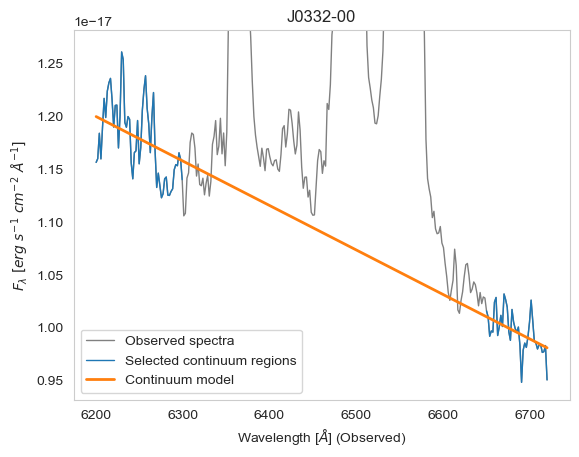

In [5]:
# Define the regions where to fit the continuum
w1c = 6200 * u.angstrom #segment on the left
w2c = 6300 * u.angstrom
w3c = 6650 * u.angstrom #on the right
w4c = 6720 * u.angstrom

# Fit the continuum and estimate the noise
wlimits_cont = ([w1c,w2c],[w3c,w4c])
mask_cont = (wave > w1c) & (wave < w4c)
poly_cont,noise=fit_continuum(wave,flux,wlimits_cont)

# For plotting the chosen region of continuum
wave_cont = wave[mask_cont]
flux_cont = flux[mask_cont]
flux_cont_model = poly_cont(wave_cont)
mask_cont_blue = (wave > w1c) & (wave < w2c)   
mask_cont_red = (wave > w3c) & (wave < w4c)

sns.set_palette('tab10',8)
xlabel=r"Wavelength [$\AA$] (Observed)"
ylabel='$F_\lambda$ $[erg\ s^{-1}\ cm^{-2}\ \AA^{-1}]$'
plt.plot(wave_cont,flux_cont*norm,linewidth=1,color="gray",label="Observed spectra")
plt.plot(wave[mask_cont_blue],flux[mask_cont_blue]*norm,label='Selected continuum regions',color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave[mask_cont_red],flux[mask_cont_red]*norm,color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave_cont,flux_cont_model*norm,label='Continuum model',color=sns.color_palette('tab10')[1],linewidth=2)
plt.legend()
plt.grid()
plt.ylim(np.median(flux_cont*norm.value)-0.20*np.median(flux_cont*norm.value),np.median(flux_cont*norm.value)+0.10*np.median(flux_cont*norm.value))
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(tgt_name)

### Modeling of the [OIII] emission lines

In [6]:
# Define the line region
w1 = 4915*(1+redshift) *u.angstrom #below [OIII]4959
w2 = 5055*(1+redshift) *u.angstrom #above [OIII]5007
mask = (wave > w1) & (wave < w2) 

flux_reg = flux[mask] #Flux in the line region
wave_reg = wave[mask] #Line region
cont_reg_model = poly_cont(wave_reg)  #Continuum contribution in the line region
flux_reg_nocont=flux_reg - cont_reg_model #Flux without the continuum

# Define the initial parameters for the model
wave_O3r = 5007*(1+redshift)*u.angstrom
wave_O3b = 4959*(1+redshift)*u.angstrom
stddev_n = 5*u.angstrom #sigma
amp_O3r = flux_reg_nocont[np.argmin(abs(wave_reg-wave_O3r))] #flux of the nearest point to the central position of the line (wave_o3)

In [7]:
# Choosing the gaussian components for each emission line
c1 = models.Gaussian1D(amplitude=amp_O3r/2, mean=wave_O3r-2*u.angstrom, stddev=stddev_n,name='[OIII]5007n1')
c2 = models.Gaussian1D(name='[OIII]4959n1')
c3 = models.Gaussian1D(amplitude=amp_O3r/2, mean=wave_O3r+2*u.angstrom, stddev=stddev_n,name='[OIII]5007n2')
c4 = models.Gaussian1D(name='[OIII]4959n2')
c5 = models.Gaussian1D(amplitude=amp_O3r/3, mean=wave_O3r, stddev=3*stddev_n,name='[OIII]5007i')
c6 = models.Gaussian1D(name='[OIII]4959i')
c7 = models.Gaussian1D(amplitude=amp_O3r/9, mean=wave_O3r, stddev=9*stddev_n,name='[OIII]5007b')
c8 = models.Gaussian1D(name='[OIII]4959b') 

# Conditions to the gaussian amplitudes
c1.amplitude.bounds=(0,None)
c2.amplitude.bounds=(0,None)
c3.amplitude.bounds=(0,None)
c4.amplitude.bounds=(0,None)
c5.amplitude.bounds=(0,None)
c6.amplitude.bounds=(0,None)
c7.amplitude.bounds=(0,None)
c8.amplitude.bounds=(0,None)

# Relations between [OIII]5007 and [OIII]4959 lines 
c2.mean.tied = tie_center_OIIIn1 #solidarity
c2.stddev.tied = tie_stddevn_OIIIn1 #same kinematic fwhm
c2.amplitude.tied = tie_ampl_OIIIn1 #ratio between the line (amplitude)
c4.mean.tied = tie_center_OIIIn2 #solidarity
c4.stddev.tied = tie_stddevn_OIIIn2 #same kinematic fwhm
c4.amplitude.tied = tie_ampl_OIIIn2 #ratio between the line (amplitude)
c6.mean.tied = tie_center_OIIIi #solidarity 
c6.stddev.tied = tie_stddevn_OIIIi #same kinematic fwhm
c6.amplitude.tied = tie_ampl_OIIIi #ratio between the line (amplitude)
c8.mean.tied = tie_center_OIIIb #solidarity 
c8.stddev.tied = tie_stddevn_OIIIb #same kinematic fwhm
c8.amplitude.tied = tie_ampl_OIIIb #ratio between the line (amplitude)

line_combo = c1 + c2 + c3 + c4 + c5 + c6 + c7 + c8 #Gaussians to fit



Initial parameters of the parametric model [9.77337821e-01 6.55669893e+03 2.49956533e+00 3.25779274e-01
 6.49392970e+03 2.47563625e+00 2.85455562e+00 6.55868634e+03
 5.54951416e+00 9.51518541e-01 6.49589808e+03 5.49638701e+00
 1.95099627e+00 6.55563215e+03 9.90941785e+00 6.50332091e-01
 6.49287313e+03 9.81455204e+00 1.21635170e-01 6.53144257e+03
 4.52538041e+01 4.05450568e-02 6.46891513e+03 4.48205760e+01]


Initial velocities of the non-parametric analysis [ 6557.29873507  1230.56820571  -509.93625052 -1662.53997305
   642.66747201   -27.33155454  -266.57719466]


 -------- 


 Executing simulation


[OIII]5007n1
1.4818210381804158e-16 erg / (A cm2 s) 1.1388601161891252 2.0723164656798465e-17 erg / (A cm2 s)
 Center= 6556.73 +/- 0.16
 FWHM= 2.846e+02 km / s +/- 2.840e+01 km / s
 Flux= 1.482e-16 erg / (A cm2 s) +/- 2.891e-17 Angstrom erg / (A cm2 s)
 EW= 6.28 +/- 1.23 Angstrom
 
[OIII]4959n1
4.892117079407979e-17 erg / (A cm2 s) 1.1673556317986717 2.0723164656798465e-17 erg / (A cm2 s)
 Center= 6493.96 +/- 0.16
 FWHM= 2.846e+02 km / s +/- 2.840e+01 km / s
 Flux= 4.892e-17 erg / (A cm2 s) +/- 9.546e-18 Angstrom erg / (A cm2 s)
 EW= 2.02 +/- 0.39 Angstrom
 
[OIII]5007n2
7.70172889736197e-16 erg / (A cm2 s) 1.1380220127888445 2.0723164656798465e-17 erg / (A cm2 s)
 Center= 6558.81 +/- 0.35
 FWHM= 5.981e+02 km / s +/- 2.413e+01 km / s
 Flux= 7.702e-16 erg / (A cm2 s) +/- 1.217e-16 Angstrom erg / (A cm2 s)
 EW= 32.66 +/- 5.16 Angstrom
 
[OIII]4959n2
2.542665983877542e-16 erg / (A cm2 s) 1.1665175283983906 2.0723164656798465e-17 erg / (A cm2 s)
 Center= 6496.02 +/- 0.34
 FWHM= 5.981e+02 k

Reduced chi-squared:  98.24168117240612




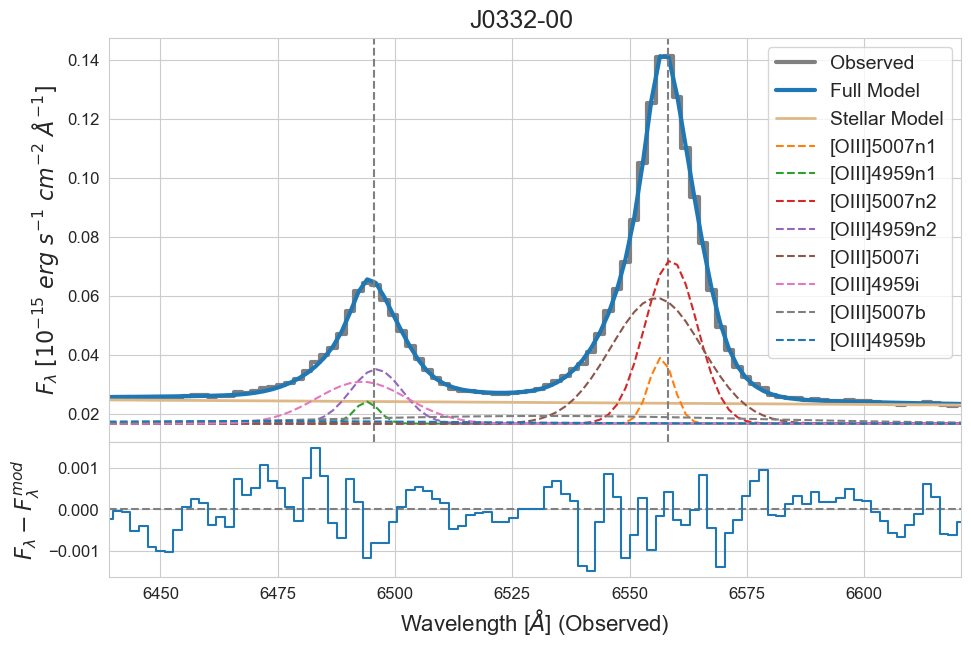

In [8]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit, line_combo_error, line_tab, chi2, blueshift, eblueshift, nonpar_fit, nonpar_error,\
outflow_fit, outflow_error, outflow_blue_fit, outflow_blue_error, outflow_red_fit, outflow_red_error,\
params_simul, params_simul_nonpar = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2)
print('\n')

#### Simulated distributions

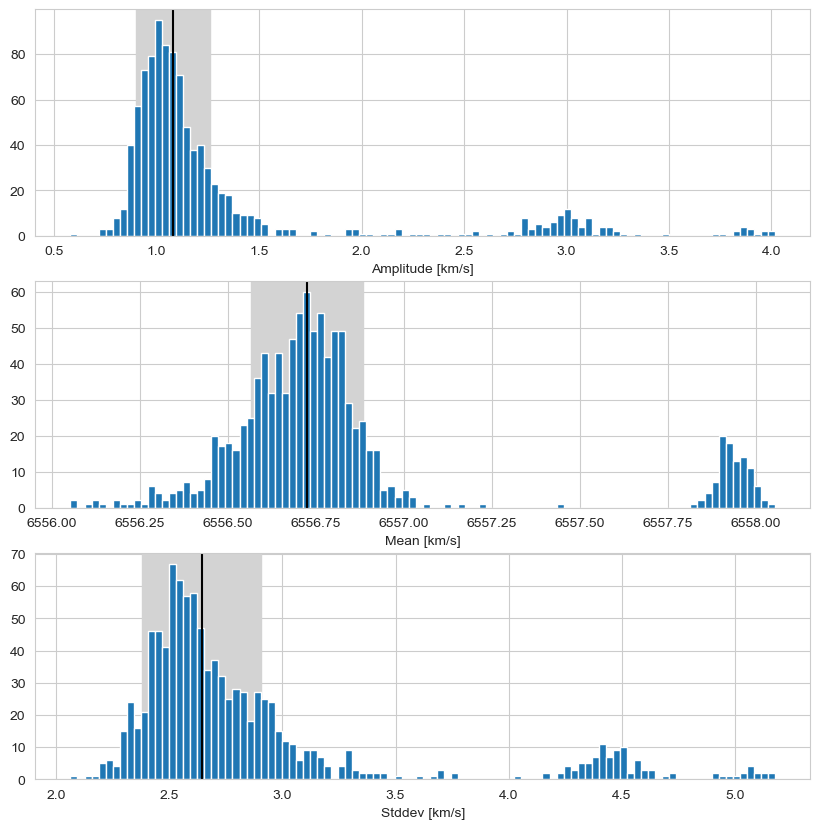

In [9]:
# Checking the simulated normal distributions for the parameters of the first modeled component
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))
ax1.axvspan(line_combo_fit.parameters[0]-line_combo_error.parameters[0],line_combo_fit.parameters[0]+line_combo_error.parameters[0],color='lightgrey')
ax1.hist(params_simul[0],bins=100)
ax1.axvline(line_combo_fit.parameters[0],color='black')
ax1.set_xlabel('Amplitude [km/s]')

ax2.axvspan(line_combo_fit.parameters[1]-line_combo_error.parameters[1],line_combo_fit.parameters[1]+line_combo_error.parameters[1],color='lightgrey')
ax2.hist(params_simul[1],bins=100)
ax2.axvline(line_combo_fit.parameters[1],color='black')
ax2.set_xlabel('Mean [km/s]')

ax3.axvspan(line_combo_fit.parameters[2]-line_combo_error.parameters[2],line_combo_fit.parameters[2]+line_combo_error.parameters[2],color='lightgrey')
ax3.hist(params_simul[2],bins=100)
ax3.axvline(line_combo_fit.parameters[2],color='black')
ax3.set_xlabel('Stddev [km/s]')
plt.show()


Text(0.5, 0, 'Asymmetry [km/s]')

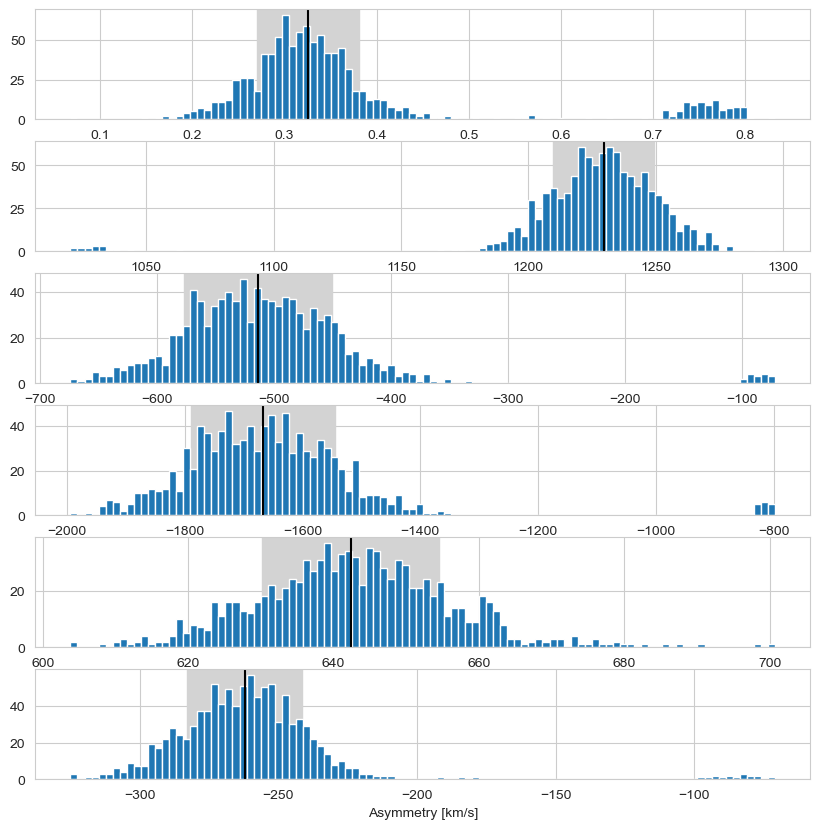

In [10]:
# Checking the simulated normal distributions for the non-parametric velocites
f,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(10,10))
ax1.axvspan(nonpar_fit[0]-nonpar_error[0],nonpar_fit[0]+nonpar_error[0],color='lightgrey')
ax1.hist(params_simul_nonpar[0],bins=100)
ax1.axvline(nonpar_fit[0],color='black')
ax1.set_xlabel('Center [km/s]')

ax2.axvspan(nonpar_fit[1]-nonpar_error[1],nonpar_fit[1]+nonpar_error[1],color='lightgrey')
ax2.hist(params_simul_nonpar[1],bins=100)
ax2.axvline(nonpar_fit[1],color='black')
ax2.set_xlabel('W80 [km/s]')

ax3.axvspan(nonpar_fit[2]-nonpar_error[2],nonpar_fit[2]+nonpar_error[2],color='lightgrey')
ax3.hist(params_simul_nonpar[2],bins=100)
ax3.axvline(nonpar_fit[2],color='black')
ax3.set_xlabel('DeltaV [km/s]')

ax4.axvspan(nonpar_fit[3]-nonpar_error[3],nonpar_fit[3]+nonpar_error[3],color='lightgrey')
ax4.hist(params_simul_nonpar[3],bins=100)
ax4.axvline(nonpar_fit[3],color='black')
ax4.set_xlabel('V05 [km/s]')

ax5.axvspan(nonpar_fit[4]-nonpar_error[4],nonpar_fit[4]+nonpar_error[4],color='lightgrey')
ax5.hist(params_simul_nonpar[4],bins=100)
ax5.axvline(nonpar_fit[4],color='black')
ax5.set_xlabel('V95 [km/s]')

ax6.axvspan(nonpar_fit[6]-nonpar_error[6],nonpar_fit[6]+nonpar_error[6],color='lightgrey')
ax6.hist(params_simul_nonpar[6],bins=100)
ax6.axvline(nonpar_fit[6],color='black')
ax6.set_xlabel('Asymmetry [km/s]')

#### Parametric model

In [11]:
# Table with the fitting parameters for each component of each line
table = QTable(names=('LineID', 'Center', 'eCenter','Flux','eFlux','FWHM','eFWHM','EW','eEW'), \
           dtype=('U12','f4', 'f4','f4', 'f4','f4', 'f4','f4','f4'))
table_par = table_add_model(line_combo_fit,table)

# Add name
table_par.add_column(tgt_name,index=0,name='Name')

# Remove non-needed ones
table_par.remove_columns(['Center','eCenter','EW','eEW',])

# Blueshift of each component
table_par.add_column(blueshift,name='Blueshift')
table_par.add_column(eblueshift,name='eBlueshift')

# Luminosity and flux percentage
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Luminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='eLuminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Percentage')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='ePercentage')

Flux_4959=[]
Flux_5007=[]
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        Flux_5007.append(table_par['Flux'][i])

    if table_par['LineID'][i][:10]=='[OIII]4959':
        Flux_4959.append(table_par['Flux'][i])

for i in range(len(table_par['LineID'])):
    table_par['Luminosity'][i]=table_par['Flux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2
    table_par['eLuminosity'][i]=table_par['eFlux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2

    if table_par['LineID'][i][:10]=='[OIII]5007':
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_5007)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_5007)

    if table_par['LineID'][i][:10]=='[OIII]4959':
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_4959)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_4959)

In [12]:
table_par

Name,LineID,Flux,eFlux,FWHM,eFWHM,Blueshift,eBlueshift,Luminosity,eLuminosity,Percentage,ePercentage
str8,str12,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
J0332-00,[OIII]5007n1,1.481821e-16,2.8913976e-17,284.6254,28.399628,-67.99534446964348,7.261825774945775,4.610980433498276e+40,8.997157963591489e+39,0.0660320296883583,0.012884474359452724
J0332-00,[OIII]4959n1,4.8921172e-17,9.545725e-18,284.6254,28.399628,-67.99534446967678,7.261825774909458,1.5222794480419182e+40,2.970341848175387e+39,0.0660320371389389,0.012884475290775299
J0332-00,[OIII]5007n2,7.701729e-16,1.2171742e-16,598.0899,24.126709,27.49905911892945,15.805949947538023,2.396546010632245e+41,3.7874792144346913e+40,0.34319987893104553,0.05423899367451668
J0332-00,[OIII]4959n2,2.5426659e-16,4.0184057e-17,598.0899,24.126709,27.49905911892945,15.805949947549724,7.912009892131508e+40,1.2504067565991787e+40,0.34319987893104553,0.05423898994922638
J0332-00,[OIII]5007i,1.0373742e-15,1.5403088e-16,1047.9263,44.51557,-115.0210966565295,12.688588823587317,3.227995793608712e+41,4.79297670889619e+40,0.46226850152015686,0.06863832473754883
J0332-00,[OIII]4959i,3.4248102e-16,5.0852096e-17,1047.9263,44.51557,-115.0210966565295,12.688588823635417,1.065697716554024e+41,1.5823639871192456e+40,0.46226853132247925,0.06863832473754883
J0332-00,[OIII]5007b,2.8836525e-16,2.9445406e-17,4823.456,299.94763,-1199.7951693266423,150.04807069802754,8.973057472701888e+40,9.16252310675642e+39,0.1284996122121811,0.01312128733843565
J0332-00,[OIII]4959b,9.520154e-17,9.721173e-18,4823.456,299.94763,-1199.7951693266757,150.04807069806435,2.962385037369022e+40,3.0249360771170404e+39,0.1284996122121811,0.013121289201080799


In [13]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/parametric.txt').to_pandas()
parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())
ascii.write(QTable.from_pandas(parametric.sort_values('Name')), 'Tables/parametric.txt', format='csv', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.2e','eLuminosity':'%8.2e','Percentage': '%8.3f','ePercentage':'%8.3f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_15740\2174204615.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())


In [14]:
table_5007 = QTable(names=('Name','LineID','Flux','eFlux','FWHM','eFWHM','Blueshift','eBlueshift','Luminosity','eLuminosity','Percentage','ePercentage'), \
           dtype=('U12','U12','f4', 'f4','f4', 'f4','f4', 'f4','f8','f8','f4', 'f4'))
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        table_5007.add_row(table_par[i])

# Save the results in a latex format for the 5007 line
texfile = ascii.read('Tables/parametric.tex',format='latex').to_pandas()
texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())
ascii.write(QTable.from_pandas(texparametric.sort_values('Name')), 'Tables/parametric.tex', format='latex', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.3e','eLuminosity':'%8.3e','Percentage': '%8.3f','ePercentage':'%8.3f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_15740\1745872242.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())


#### Non-parametric analysis

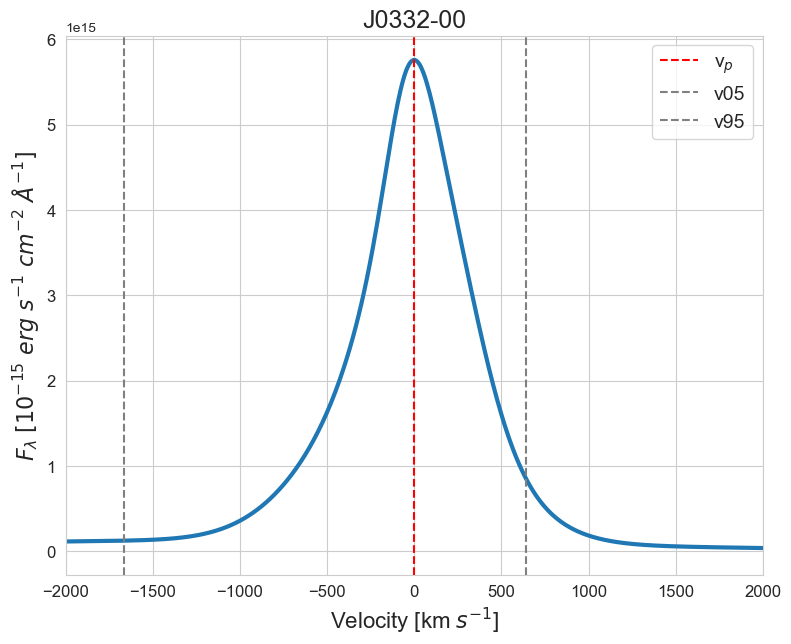

In [15]:
perform_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [16]:
table_nonpar = QTable(names=('Name', 'Wavepeak', 'Width80','DeltaV','V05','V95','Vmed','Asymmetry'),\
           dtype=('U12','f4', 'f4','f4','f4','f4','f4','f4'))
table_nonpar.add_row(np.append(tgt_name,nonpar_fit))
table_nonpar.add_columns(np.array(nonpar_error,dtype='f4'),indexes=[2,3,4,5,6,7,8],names=('eWavepeak', 'eWidth80','eDeltaV','eV05','eV95','eVmed','eAsymmetry'))

In [17]:
table_nonpar

Name,Wavepeak,eWavepeak,Width80,eWidth80,DeltaV,eDeltaV,V05,eV05,V95,eV95,Vmed,eVmed,Asymmetry,eAsymmetry
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0332-00,6557.325,0.05514442,1229.5087,19.923956,-513.569,63.263523,-1667.2041,122.33645,642.374,12.185295,-28.572483,3.1779113,-262.1202,20.688332


In [18]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/nonparametric.txt').to_pandas()
nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(nonparametric.sort_values('Name')), 'Tables/nonparametric.txt', format='csv', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asymmetry': '%8.2f','eAsymmetry': '%8.2f'})


C:\Users\HP\AppData\Local\Temp\ipykernel_15740\2927441754.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())


In [19]:
# Save the results in a latex format for the 5007 line
file = ascii.read('Tables/nonparametric.tex').to_pandas()
texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(texnonparametric.sort_values('Name')), 'Tables/nonparametric.tex', format='latex', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asymmetry': '%8.2f','eAsymmetry': '%8.2f'})


C:\Users\HP\AppData\Local\Temp\ipykernel_15740\217271521.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())


# Outflow mass, outflow mass rate and energy rate

## Giovanna's method: outflow line flux

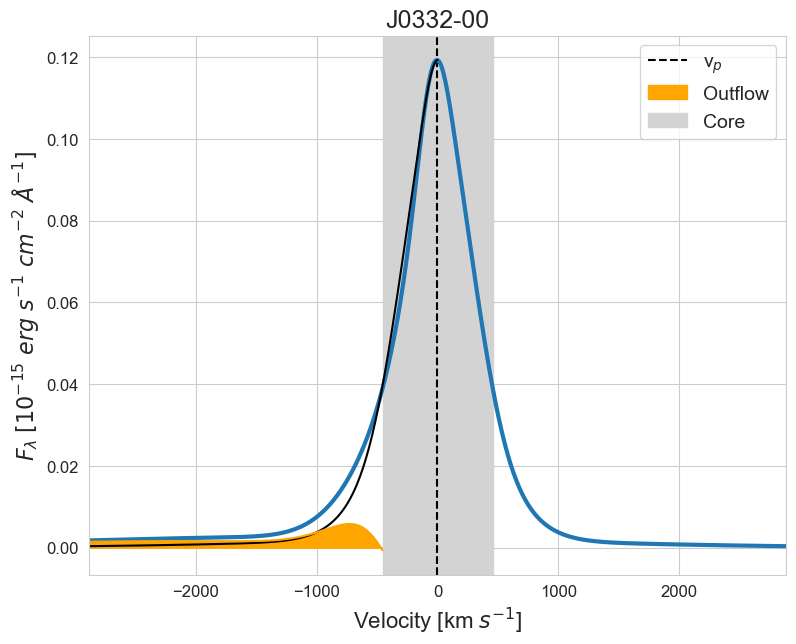

In [20]:
perform_outflow_plot(tgt_name,wave_reg,line_combo_fit,flux_norm=norm*(1+redshift)**3)

In [21]:
table_outflow = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow.add_row(np.append(tgt_name,outflow_fit))
table_outflow.add_columns(np.array(outflow_error,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow.add_column((table_outflow['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2).value,name='Loutflow')
table_outflow.add_column((table_outflow['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2).value,name='eLoutflow')

In [22]:
table_outflow

Name,Foutflow,eFoutflow,Voutflow,eVoutflow,Loutflow,eLoutflow
str12,float64,float64,float64,float64,float64,float64
J0332-00,1.2031544232737064e-16,1.239428012999237e-17,-1195.6153278132483,95.17427212760947,3.74385399030611e+40,3.8567264703549665e+39


In [23]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_giovanna.txt').to_pandas()
outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_giovanna.tex').to_pandas()
tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_15740\1200331943.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_15740\1200331943.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())


#### Outflow energetics

In [24]:
outflow_energy,outflow_energy_errors = outflow_energetics_uncertainties(table_outflow,Nsimul=200)

In [25]:
table_outflow_energy = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy.add_row(np.append(tgt_name,outflow_energy))
table_outflow_energy.add_columns(np.array(outflow_energy_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [26]:
table_outflow_energy

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0332-00,4.8658023,0.048541814,54.01739,0.078699045,1.0,0.0,36.087227,0.10600972,0.26661393,0.033964284


In [27]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_giovanna.txt').to_pandas()
outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_giovanna.tex').to_pandas()
tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_15740\2348874735.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_15740\2348874735.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())


## Non parametric method: v05 and v95

### V05 and v95

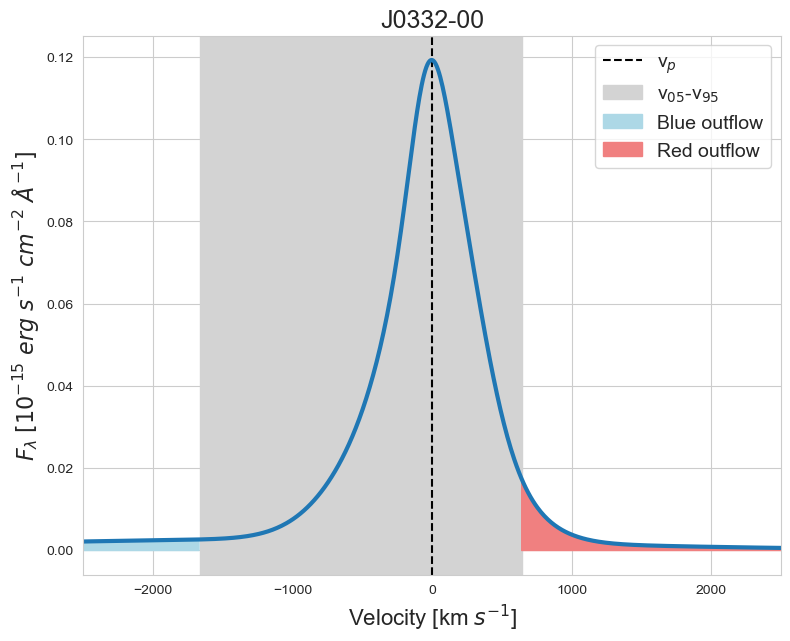

In [28]:
perform_outflow_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [29]:
table_outflow_nonpar = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_blue_fit))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_red_fit))

table_outflow_nonpar.add_column(np.array(['Blue','Red' ]),index=1,name=('Outflow'))

table_outflow_nonpar.add_columns(np.array(np.array((outflow_blue_error,outflow_red_error)).T,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow_nonpar.add_column(table_outflow_nonpar['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='Loutflow')
table_outflow_nonpar.add_column(table_outflow_nonpar['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='eLoutflow')

In [30]:
table_outflow_nonpar

Name,Outflow,eFoutflow,Foutflow,eVoutflow,Voutflow,Loutflow,eLoutflow
,,,,,,,
str12,str4,float64,float64,float64,float64,float64,float64
J0332-00,Blue,4.664919867778962e-19,1.1037910264442458e-16,134.30055812128853,-2808.4394935125165,3.4346650428905725e+40,1.4515824838113443e+38
J0332-00,Red,1.4803093182744552e-18,1.1206042351572824e-16,33.87174522848998,870.3743723979904,3.486982681684501e+40,4.606276501921956e+38


In [31]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_nonpar.txt').to_pandas()
outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_nonpar.tex').to_pandas()
tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_15740\3637349706.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_15740\3637349706.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())


#### Outflow energetics

In [32]:
outflow_energy_nonpar,outflow_energy_nonpar_errors = outflow_energetics_nonpar_uncertainties(table_outflow_nonpar,200)

In [33]:
table_outflow_energy_nonpar = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_nonpar.add_row(np.append(tgt_name,outflow_energy_nonpar))
table_outflow_energy_nonpar.add_columns(np.array(outflow_energy_nonpar_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [34]:
table_outflow_energy_nonpar

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0332-00,5.13138,0.0031252548,54.76355,0.037931252,1.0,0.0,37.17383,0.06080743,0.7617811,0.028035115


In [35]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_nonpar.txt').to_pandas()
outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_nonpar.tex').to_pandas()
tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_15740\4162063144.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_15740\4162063144.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())


## Parametric method

In [36]:
table_outflow_par = QTable(names=('Name','Loutflow','eLoutflow', 'Voutflow','eVoutflow',),\
           dtype=('U12','f8', 'f8','f8', 'f8'))
table_outflow_par.add_row([tgt_name,table_par[(table_par['LineID']=='[OIII]5007i')]['Luminosity'],table_par[(table_par['LineID']=='[OIII]5007i')]['eLuminosity'],table_par[(table_par['LineID']=='[OIII]5007i')]['Blueshift'],table_par[(table_par['LineID']=='[OIII]5007i')]['eBlueshift']])
table_outflow_par.add_row([tgt_name,table_par[(table_par['LineID']=='[OIII]5007b')]['Luminosity'],table_par[(table_par['LineID']=='[OIII]5007b')]['eLuminosity'],table_par[(table_par['LineID']=='[OIII]5007b')]['Blueshift'],table_par[(table_par['LineID']=='[OIII]5007b')]['eBlueshift']])

In [37]:
table_outflow_par

Name,Loutflow,eLoutflow,Voutflow,eVoutflow
str12,float64,float64,float64,float64
J0332-00,3.227995793608712e+41,4.79297670889619e+40,-115.0210966565295,12.688588823587317
J0332-00,8.973057472701888e+40,9.16252310675642e+39,-1199.7951693266423,150.04807069802754


#### Energetics

In [38]:
outflow_energy_par,outflow_energy_par_errors = outflow_energetics_nonpar_uncertainties(table_outflow_par,Nsimul=200)

In [39]:
table_outflow_energy_par = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_par.add_row(np.append(tgt_name,outflow_energy_par))
table_outflow_energy_par.add_columns(np.array(outflow_energy_par_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [40]:
table_outflow_energy_par

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0332-00,5.9046516,0.050177872,54.40451,0.113577805,1.0,0.0,36.462505,0.16798265,0.8586099,0.1141965


In [41]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_par.txt').to_pandas()
outflow_energy_par = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_par.sort_values('Name')), 'Tables/outflow_energy_par.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_par.tex').to_pandas()
tex_outflow_energy_par = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_par.sort_values('Name')), 'Tables/outflow_energy_par.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_15740\2069511822.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_par = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_15740\2069511822.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_par = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())


## Comparisson of outflow energetic methods

#### Giovanna's method (1/3 total flux)

In [42]:
table_outflow_energy

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0332-00,4.8658023,0.048541814,54.01739,0.078699045,1.0,0.0,36.087227,0.10600972,0.26661393,0.033964284


#### Non parametric method (v05 and v95)

In [43]:
table_outflow_energy_nonpar

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0332-00,5.13138,0.0031252548,54.76355,0.037931252,1.0,0.0,37.17383,0.06080743,0.7617811,0.028035115


#### Parametric methods (broad component)

In [44]:
table_outflow_energy_par

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0332-00,5.9046516,0.050177872,54.40451,0.113577805,1.0,0.0,36.462505,0.16798265,0.8586099,0.1141965
